# Домашнее задание № 9

# Задание 1 (10 баллов)

Визуализируйте attention для одного любого текста после нескольких последовательных эпох обучения, чтобы проанализировать как модель учится понимать текст.
Для этого вам понадобится так изменить код модели из семинара, чтобы Block класс возвращал attention активации (последнее значение wei), а также все остальные классы, которые вызывают Block, чтобы они ожидали, что модель вернет не только out но и wei. В самом верхнеуровневом классе BigramLanguageModel вы можете добавить атрибут last_attentions и в forward перезаписывать его значения последним значением attention (но можно придумать и другой способ). После каждой эпохи вызовите модель на одном примере из датасета и сохраните last_attentions во внешнюю переменную, чтобы потом отдельно заняться визуализацией. Визуализируйте attentions как heatmap'ы (например в searborn). У вас будет attention матрица для каждого слоя и для каждого head в модели. Для каждой нужно будет сделать свой хитмап.
Должно получиться что-то похожее на (только несколько для каждой эпохи)
![](https://www.kdnuggets.com/wp-content/uploads/How_to_Visualize_Model_Internals_and_Attention_in_Hugging_Face_Transformers_3.png)

In [9]:
!pip install rusenttokenize
!pip install tokenizers

In [10]:
import torch

import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
from rusenttokenize import ru_sent_tokenize

In [11]:
data = pd.read_csv('https://github.com/mannefedov/compling_nlp_hse_course/raw/refs/heads/master/data/lenta_40k.csv.zip')

In [12]:

sentences = []
for text in data.text.values:
    sentences.extend(ru_sent_tokenize(text))

In [13]:
f = open('corpus.txt', 'w')
for sent in sentences:
    f.write(sent + '\n')
f.close()

In [14]:

sentences = open('corpus.txt').read().splitlines()

In [15]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer
from tokenizers import decoders

In [16]:

tokenizer = Tokenizer(BPE())
tokenizer.pre_tokenizer = Whitespace()
trainer = BpeTrainer(special_tokens=["[PAD]", "[BOS]", "[EOS]"], end_of_word_suffix='</w>')

In [17]:
tokenizer.train(files=["corpus.txt"], trainer=trainer)

In [18]:

# сохраним токенизатор
tokenizer.save('tokenizer')

In [19]:

# при перезапуске можно просто перезагрузить готовый токенизатор
# также он понадобится если мы решим сохранить модель
tokenizer = Tokenizer.from_file("tokenizer")

In [20]:
tokenizer.decoder = decoders.BPEDecoder()

In [21]:

vocab_size = tokenizer.get_vocab_size()

In [23]:
def encode(text, tokenizer):
    return [tokenizer.token_to_id('[BOS]')] + tokenizer.encode(text).ids + [tokenizer.token_to_id('[EOS]')]

PAD_IDX = tokenizer.token_to_id('[PAD]')

In [22]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, sentences, tokenizer, max_len=32):
        # каждое предложение преобразуется в последовательность индексов
        # а списки преобразуются в тензоры
        self.encoded_texts = [torch.LongTensor(encode(sent, tokenizer)[-max_len:]) for sent in sentences]
        # чтобы составить один общий обучающий тензор нужно сравнять длины последовательностей отдельных текстов
        # в торче не такая удобная функция паддинга, поэтому транкация (отрезание лишнего) происходит уже выше
        self.X = torch.nn.utils.rnn.pad_sequence(self.encoded_texts, padding_value=PAD_IDX, batch_first=True)
        self.length = len(self.encoded_texts)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        # обучающий пример для GPT составляется из одного текста
        # x - это все токены кроме последнего
        # y - это все токены кроме первого
        # другими словами, y это x со сдвигом вправо
        # каждый отдельный элемент в y - следующий токен для соответствующего элемента в x
        # tokens = [1,2,3,4,5,0]
        # x = [1,2,3,4,0]
        # y = [2,3,4,5,0]

        # 1 -> 2
        # 1,2 -> 3
        # 1,2,3 -> 4
        # 1,2,3,4 -> 5
        # teacher forcing

        x = self.X[index][:-1]
        y = self.X[index][1:]

        # чтобы не учитывать паддинг нам нужно создать маску
        mask = x!=PAD_IDX

        return x, y, mask

In [24]:
n = int(0.9*len(sentences)) # first 90% will be train, rest val
sentences_train = sentences[:n]
sentences_val = sentences[n:]

MAX_LEN = 64

In [25]:

training_set = Dataset(sentences_train, tokenizer, MAX_LEN)
val_set = Dataset(sentences_val, tokenizer, MAX_LEN)

In [ ]:
training_generator = torch.utils.data.DataLoader(training_set, batch_size=200, shuffle=True, )
val_generator = torch.utils.data.DataLoader(training_set, batch_size=200, shuffle=False)

In [ ]:
# hyperparameters
block_size = MAX_LEN
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0

In [ ]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        B,T,C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2,-1) * C**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        if mask is not None:
            wei.masked_fill(~mask.unsqueeze(1), float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei @ v
        return out, wei #последнее значение wei

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        out = []
        attentions = []
        for h in self.heads:
          out_h, attentions_h = h(x, mask)
          out.append(out_h)
          attentions.append(attentions_h)
        out = torch.cat(out, dim=-1)
        out = self.dropout(self.proj(out))
        return out, attentions

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, inp):
        # print(inp)
        x, mask, attention = inp
        x_sa, attention = self.sa(self.ln1(x), mask)
        x = x + x_sa
        x = x + self.ffwd(self.ln2(x))
        return (x, mask, attention)

In [ ]:
# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None, mask=None, attention=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x, mask, last_attentions = self.blocks((x, mask, attention)) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets, ignore_index=PAD_IDX)

        return logits, loss, last_attentions

    def generate(self, idx, max_new_tokens, stop_token):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss, attentions = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)# (B, 1)
            if idx_next == stop_token:
                break
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [ ]:
model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

4.073392 M parameters


In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [ ]:
def train(model, iterator, optimizer, print_every=10):
    epoch_loss = []
    model.train()

    for i, (xs, ys, mask) in enumerate(iterator):
        optimizer.zero_grad()
        logits, loss, attentions = model(xs.to(device), ys.to(device), mask.to('cuda'))

        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())

        if not (i+1) % print_every:
            print(f'Loss: {torch.Tensor(epoch_loss).mean(-1)}')

    return torch.Tensor(epoch_loss).mean(-1)

def evaluate(model, iterator):
    epoch_loss = []
    model.eval()
    with torch.no_grad():
        for xs, ys, mask in iterator:
            logits, loss, attentions = model(xs.to(device), ys.to(device), mask.to('cuda'))
            epoch_loss.append(loss.item())

    return torch.Tensor(epoch_loss).mean(-1)

In [ ]:
def get_attention(model, val_set):
    model.eval()
    with torch.no_grad():
        xs, ys, mask = val_set.__getitem__(2048)
        xs = xs.unsqueeze(0)
        ys = ys.unsqueeze(0)
        mask = mask.unsqueeze(0)
        logits, loss, attentions = model(xs.to(device), ys.to(device), mask.to('cuda'))

    return attentions

In [ ]:
train_losses = []
eval_losses = []
epochs_attentions = dict()
for i in range(10):
    print(i)
    train_losses.append(train(model, training_generator, optimizer, 100))
    eval_loss = evaluate(model, val_generator)
    print('Eval - ', eval_loss.item())
    eval_losses.append(eval_loss)
    for _ in range(3):
        pred = model.generate(torch.LongTensor([[tokenizer.token_to_id('[BOS]')]]).to('cuda'), 200, tokenizer.token_to_id('[EOS]'))
        print(tokenizer.decoder.decode([tokenizer.id_to_token(i) for i in pred.detach().cpu().numpy()[0]][1:-1]))
    epochs_attentions[i] = get_attention(model, val_set)

0
Loss: 8.56354808807373
Loss: 8.157004356384277
Loss: 7.957697868347168
Loss: 7.818552017211914
Loss: 7.702880859375
Loss: 7.602161407470703
Loss: 7.509402275085449
Loss: 7.424017429351807
Loss: 7.34226131439209
Loss: 7.265638828277588
Loss: 7.195275783538818
Loss: 7.127185821533203
Loss: 7.064452171325684
Loss: 7.004013538360596
Loss: 6.948268413543701
Loss: 6.894915580749512
Loss: 6.844972610473633
Loss: 6.798150539398193
Loss: 6.753629684448242
Loss: 6.710939884185791
Loss: 6.669790744781494
Loss: 6.630966663360596
Eval -  5.743413925170898
В пояснительной записке за« поклонников » устроили формы президентские образец служащие налогов
По данным посольства , речь , его копию боксера занимали установить банки найти три миллиона , подходявлено в год после контроля , были использованы долгосростарта остаток международных запрещенных звезд при выпуске времени оплачиг , адресота грамоки с 11 лет
Оно приходится " посетить стекла с дочь " Нью - Йорк " для посадки участков
1
Loss: 5.7232599

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
xs, ys, mask = val_set[2048]
tokens = []
for i in xs.cpu().numpy():
  tok = tokenizer.id_to_token(i)
  if tok != '[PAD]':
    tokens.append(tok)
tokens

['[BOS]',
 'Кроме</w>',
 'того</w>',
 ',</w>',
 'несколько</w>',
 'дней</w>',
 'назад</w>',
 'он</w>',
 'обратился</w>',
 'к</w>',
 'властям</w>',
 'королевства</w>',
 'с</w>',
 'просьбой</w>',
 'предоставить</w>',
 'ему</w>',
 'политическое</w>',
 'убежище</w>',
 '.</w>',
 '[EOS]']

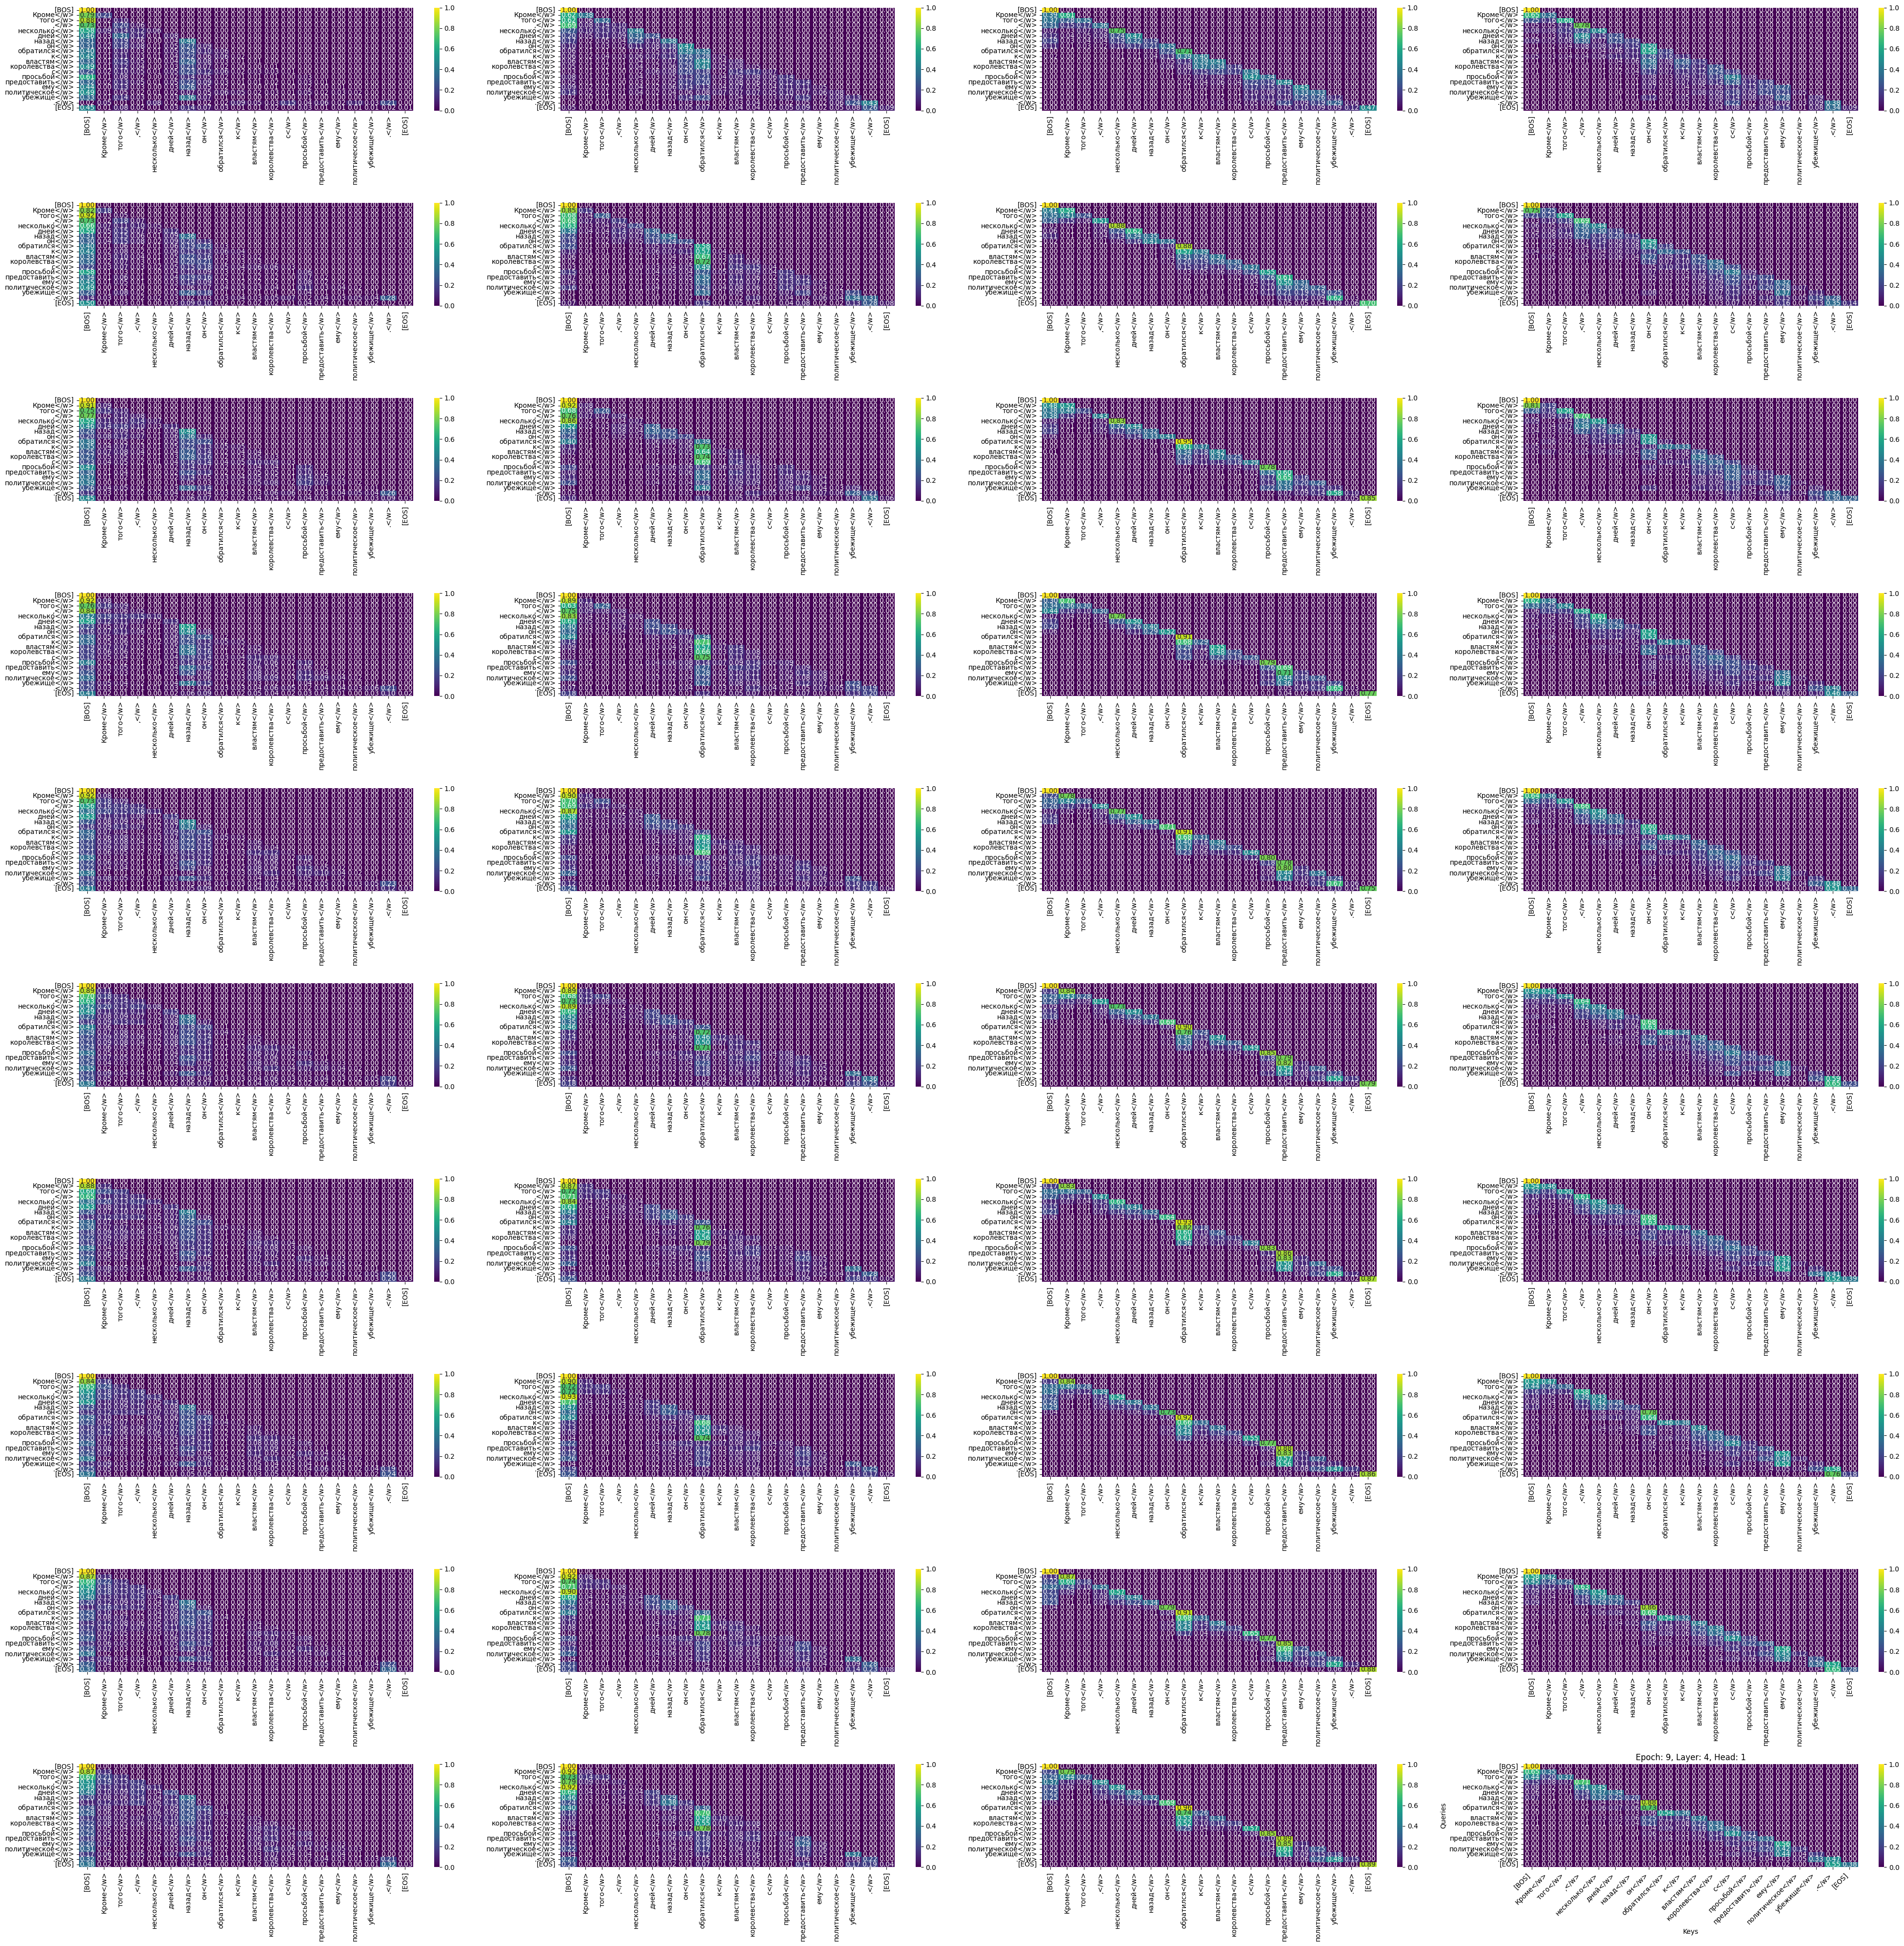

In [46]:
fig, axes = plt.subplots(nrows=len(epochs_attentions), ncols=4, figsize = (40, 40))

for epoch, layers in epochs_attentions.items():
    for layer_index, heads in enumerate(layers):
        for head_index, attention_tensor in enumerate(heads):
            ax = axes[epoch, layer_index + head_index]
            attention_matrix = attention_tensor.squeeze(0).cpu().numpy()[:len(tokens), :len(tokens)]
            sns.heatmap(attention_matrix, cmap='viridis', annot=True, fmt=".2f", xticklabels=tokens, yticklabels=tokens, ax=ax)
            plt.title(f'Epoch: {epoch}, Layer: {layer_index + 1}, Head: {head_index + 1}')
            plt.xlabel('Keys')
            plt.ylabel('Queries')
            plt.xticks(rotation=45, ha='right')
            plt.yticks(rotation=0)
plt.tight_layout()
plt.show()